In [3]:
import time
from dataclasses import field
from typing import Any
import jax
import numpy as np
from flax import linen as nn
from flax.training import train_state
from jax import numpy as jnp



# For classes
import inspect 
import random
import matplotlib.pyplot as plt
import collections
from dataclasses import field
from dataclasses import dataclass

In [4]:
get_seed = lambda: random.randint(0, 1e6)
get_key = lambda: jax.random.PRNGKey(get_seed())

In [5]:
class HyperParameters:
    '''Parent class to save parameters not ignored'''

    # Save paremeters not ignored to self
    # See HyperparametersMixin from Pytorch Lightning API
    def save_hyperparameters(self, * args, ignore=[]):

        # Get local variables passed to function (a=b,...) -> {a:b,...}
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)

        # Get parameters not ignored and place in dictionary
        self.hparams = {k: v for k, v in local_vars.items() if k not in
                        set(ignore + ['self']) and not k.startswith('_')}

        # Save parameter values to self. {a:b} -> self.a = b
        for k, v in self.hparams.items():
            setattr(self, k, v)


class ProgressBoard(HyperParameters):  # @save
    """Plot data points in animation."""

    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):

        # Create named tuple Point
        Point = collections.namedtuple('Point', ['x', 'y'])

        # If new data, make dictionary for points and data
        if not hasattr(self, 'raw_points'):
            # Make an ordered dictionary
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()

        # If no data, initialize data with an array
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []

        # Get current data and append new data
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        # print (self.raw_points, self.data)
        # Return if not every_n
        if len(points) != every_n:
            return

        # calculate the mean for line
        def mean(x): return sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))

        points.clear()
        if self.fig is None:
            self.fig = plt.figure()
        plt_lines, labels = [], []

        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot([p.x for p in v],
                                      [p.y for p in v], linestyle=ls, color=color)[0])
            labels.append(k)
        axes = plt.gca()
        if self.ylim:
            axes.set_ylim(self.ylim)
        if not self.xlabel:
            self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)


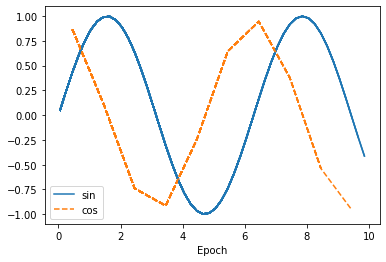

In [6]:
board = ProgressBoard('Epoch')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

In [7]:
@dataclass
class Module(HyperParameters):
    plot_train_per_epoch: int = field(default=2, init=False)
    plot_valid_per_epoch: int = field(default=1, init=False)
    board: ProgressBoard = field(
        default_factory=lambda: ProgressBoard(), init=False)

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X, *args):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X, *args)

    def __call__(self, X, *args):
        return self.forward(X, *args)

    def plot(self, key, value, train):
        assert hasattr(self, 'trainer'), 'Trainer is not initiated'
        self.board.xlabel = 'epoch'

        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value,
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

        def training_step(self, params, batch, state):
            l, grads = jax.value_and_grad(self.loss)(params, batch[:-1], batch[-1], state)
            self.plot('loss', l, train=True)
            return l

        def validation_step(self, params, batch, state):
            l = self.loss(params, batch[:-1], batch[-1], state)
            self.plot('loss', l, train=False)

        def configure_optimizers(self):
            raise NotImplementedError

        def apply_init(self, dummy_input, key):
            params = self.init(key, *dummy_input)
            return params



mod = Module()
mod.plot_train_per_epoch


2

In [8]:
class DataModule(HyperParameters):  #@save
    def __init__(self, root='data'):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        return tensors
        # Use Tensorflow Datasets & Dataloader. JAX or Flax do not provide
        # any dataloading functionality
        #shuffle_buffer = tensors[0].shape[0] if train else 1
        #return tfds.as_numpy(
        #    tf.data.Dataset.from_tensor_slices(tensors).shuffle(
        #        buffer_size=shuffle_buffer).batch(self.batch_size))

In [9]:
class Trainer(HyperParameters):
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data, key=None):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()

        if key is None:
            root_key = get_key()
        else:
            root_key = key

        params_key, dropout_key = jax.random.split(root_key)
        key = {'params': params_key, 'dropout': dropout_key}

        dummy_index = next(iter(self.train_dataloader))[:-1]
        variables = model.apply_init(dummy_index,key=key)
        params = variables['params']

        if 'batch_stats' in variables.keys():
            batch_stats = variables['batch_stats']
        else:
            batch_stats = {}

        class TrainState(train_state.TrainState):
            batch_stats: Any
            dropout_rng: jax.random.PRNGKeyArray

        self.state = TrainState.create(apply_fn=model.apply,
                                       params=params,
                                       batch_stats=batch_stats,
                                       dropout_rng=dropout_key,
                                       tx=model.configure_optimizers())        


        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    
    def fit_epoch(self):
        raise NotImplementedError

tn = Trainer(10)
tn.hparams

{'max_epochs': 10, 'num_gpus': 0, 'gradient_clip_val': 0}

In [10]:
class SyntheticRegressionData(DataModule):
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32, seed=0):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        key = jax.random.PRNGKey(seed)
        key1, key2 = jax.random.split(key)
        self.X = jax.random.normal(key1, (n, w.shape[0]))
        noise = jax.random.normal(key2, (n, 1))*noise
        self.y = self.X @ w.reshape(-1, 1) + b + noise

    def get_dataloader(self, train):
        if train:
            indices = list(range(0, self.num_train))
            # The examples are read in random order
            random.shuffle(indices)
        else:
            indices = list(range(self.num_train, self.num_train+self.num_val))
        for i in range(0, len(indices), self.batch_size):
            batch_indices = jnp.array(indices[i: i+self.batch_size])
            yield self.X[batch_indices], self.y[batch_indices]




In [11]:
data = SyntheticRegressionData(w=jnp.array([2, -3.4]), b=4.2)
print (f'features: {data.X[0]}, \nlabel={data.y[0]}')

features: [-0.86997527 -3.2320356 ], 
label=[13.438176]


In [12]:
X, y = next(iter(data.train_dataloader()))
print(f'X shape: {X.shape} \ny shape: {y.shape}')

X shape: (32, 2) 
y shape: (32, 1)


In [88]:

len(data.train_dataloader())


TypeError: object of type 'generator' has no len()

In [14]:
class LinearRegressionScratch(Module):
    num_inputs: int
    lr: float
    sigma: float = 0.01

    def setup(self):
        self.w = self.param('w')
        self.b = self.param('b')

a = LinearRegressionScratch()
a.setup()


AttributeError: 'LinearRegressionScratch' object has no attribute 'param'

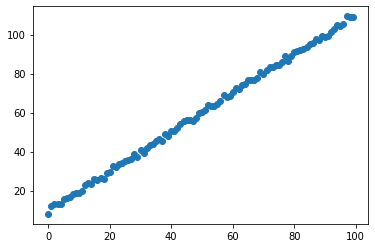

In [160]:
class Model:
    def __init__(self, n_in, n_out=1, m=0, b = 0, seed=0):
        key = jax.random.PRNGKey(seed)

        self.x = jnp.arange(n_in, dtype=jnp.float32)
        self.m = m
        self.b = b
        noise = jax.random.normal(key, (n_in,), dtype=jnp.float32)
        self.y = self.m*self.x + self.b + noise

mymodel = Model(100, m=1.0, b = 10.)
#mymodel.y.flatten().shape
#plt.scatter(mymodel.x, mymodel.y);
mymodel.x.shape, mymodel.y.shape
plt.scatter(mymodel.x, mymodel.y);

In [212]:
x = jnp.arange(mymodel.y.size, dtype=jnp.float32)

m = jnp.array(0.0)
b = jnp.array(0.0)

params = dict(m=jnp.array(m),b=jnp.array(b))

def test(params):
    return jnp.sum((params['m']*x + params['b'] - mymodel.y)**2.0)**0.5

for i in range(20001):
    if i %2000 == 0:
        print()
        print (f"m = {params['m']}, b = {params['b']}")

    grads = jax.grad(test)(params)
    
    #params['m'] += -0.0001*grads['m']
    #params['b'] += -0.0001*grads['b']

    params = jax.tree_map(lambda p, g: p - 0.0001 * g, params, grads)

    if i %2000 == 0:
        print (f"grad m = {grads['m']}, grad b = {grads['b']}")
        print (f'Loss equals {test(params)}')


#plt.plot(x, mymodel.y)
#plt.plot(x, m*x + b)

#m = 1.0
#print (jnp.mean((m*x + b - mymodel.y)**2.0))

params['m'] = 1.0
params['b'] = 10.0
print (test(params))




m = 0.0, b = 0.0
grad m = -571.325927734375, grad b = -8.993230819702148
Loss equals 629.8775024414062

m = 1.137751817703247, b = 0.9976820945739746
grad m = 0.0740509033203125, grad b = -4.930723667144775
Loss equals 45.948909759521484

m = 1.1229221820831299, b = 1.9813039302825928
grad m = 0.07330703735351562, grad b = -4.904034614562988
Loss equals 41.11027526855469

m = 1.108188509941101, b = 2.9585635662078857
grad m = 0.07335662841796875, grad b = -4.86629056930542
Loss equals 36.334022521972656

m = 1.0935930013656616, b = 3.9266586303710938
grad m = 0.0725250244140625, grad b = -4.810912132263184
Loss equals 31.64693260192871

m = 1.0792049169540405, b = 4.880992412567139
grad m = 0.070465087890625, grad b = -4.7260613441467285
Loss equals 27.09210968017578

m = 1.0651428699493408, b = 5.813702583312988
grad m = 0.0690765380859375, grad b = -4.58970832824707
Loss equals 22.741252899169922

m = 1.0516178607940674, b = 6.710794925689697
grad m = 0.065521240234375, grad b = -4.

In [194]:
params = dict(m=jnp.array(m),b=jnp.array(b))
params.keys()

dict_keys(['m', 'b'])

In [159]:
def loss (params, y):
    x = jnp.arange(y.size, dtype=jnp.float32)
    off = (params['m']*x + params['b'] - y)**2.0
    return off.mean()

m = jnp.array(0.1)
b = jnp.array(0.1)
params = []
params = dict(m=jnp.array(m),b=jnp.array(b))

for i in range(100):
    
    
    #params['m'] = m
    #params['b'] = b
    if i%20 == 0:
        print (f'\n* Epoch {i}')
        print (f" * params: {params['m'].item() = }, {params['b'].item() = }")

    myloss = loss(params, mymodel.y)
    gloss = jax.grad(loss)(params, mymodel.y)
    if i%20 == 0:
        print (gloss)

    if i < 40:
        lr = 0.00001
    elif i < 60:
        lr = 0.0001
    else:
        lr = 0.001
    
    params['m'] = params['m'] - lr*gloss['m']
    params['b'] = params['b'] - lr*gloss['b']
    #print (i, myloss)
    #print (myloss)
    if i%20 == 0:
        print (f" * grad: {gloss['m'].item() = }, {gloss['b'].item() = }")
        print (myloss)



    



* Epoch 0
 * params: params['m'].item() = 0.10000000149011612, params['b'].item() = 0.10000000149011612
{'b': Array(-109.064255, dtype=float32, weak_type=True), 'm': Array(-6903.718, dtype=float32, weak_type=True)}
 * grad: gloss['m'].item() = -6903.7177734375, gloss['b'].item() = -109.06425476074219
3654.2393

* Epoch 20
 * params: params['m'].item() = 0.8809539079666138, params['b'].item() = 0.11277005076408386
{'b': Array(-31.724281, dtype=float32, weak_type=True), 'm': Array(-1773.9299, dtype=float32, weak_type=True)}
 * grad: gloss['m'].item() = -1773.929931640625, gloss['b'].item() = -31.724281311035156
264.91882

* Epoch 40
 * params: params['m'].item() = 1.0816173553466797, params['b'].item() = 0.11679121851921082
{'b': Array(-11.850559, dtype=float32, weak_type=True), 'm': Array(-455.77502, dtype=float32, weak_type=True)}
 * grad: gloss['m'].item() = -455.7750244140625, gloss['b'].item() = -11.85055923461914
41.12108

* Epoch 60
 * params: params['m'].item() = 1.1508668661117